In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, roc_auc_score,confusion_matrix,f1_score, recall_score,precision_score
from sklearn.model_selection import train_test_split
import xgboost
import warnings
warnings.filterwarnings('ignore')
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
sns.set(rc = {'figure.figsize':(12,5)});
plt.figure(figsize=(12,5))

In [3]:
# data = pd.read_csv('train.csv',header = 0)

In [66]:
data = pd.read_csv('train_sample.csv',header = 0)

In [67]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
ip                 100000 non-null int64
app                100000 non-null int64
device             100000 non-null int64
os                 100000 non-null int64
channel            100000 non-null int64
click_time         100000 non-null object
attributed_time    227 non-null object
is_attributed      100000 non-null int64
dtypes: int64(6), object(2)
memory usage: 6.1+ MB
None


In [68]:
data.isnull().sum()

ip                     0
app                    0
device                 0
os                     0
channel                0
click_time             0
attributed_time    99773
is_attributed          0
dtype: int64

### Data preprocessing

In [69]:
Target = ['is_attributed']
Feature = ['ip', 'app', 'device', 'os', 'channel']
# convert categorical data from intergers to categories
for feature in Feature:
    data[feature] = data[feature].astype('category')

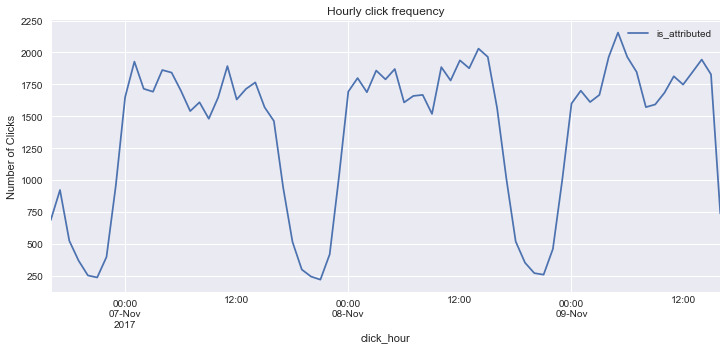

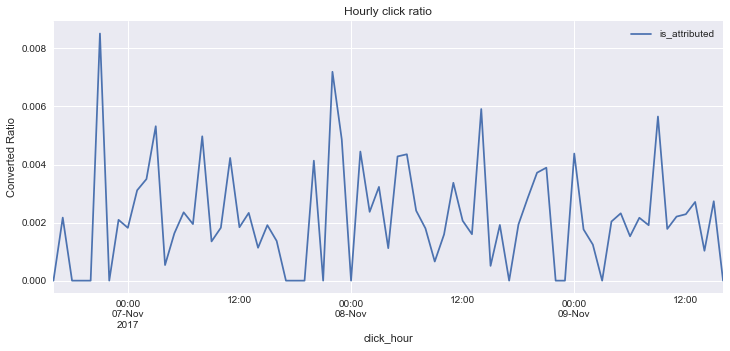

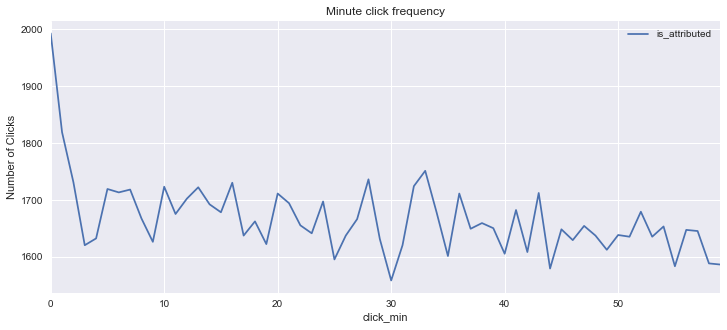

In [70]:
# set click time to time series
data['click_time'] = pd.to_datetime(data['click_time'])
data['click_hour'] = data['click_time'].dt.round('H')

#check for hourly patterns
data[['click_hour','is_attributed']].groupby(['click_hour'], as_index=True).count().plot()
plt.title('Hourly click frequency')
plt.ylabel('Number of Clicks')

#check for hourly patterns
data[['click_hour','is_attributed']].groupby(['click_hour'], as_index=True).mean().plot()
plt.title('Hourly click ratio')
plt.ylabel('Converted Ratio')

# conclusion: extract hour as a feature
data['click_hour'] = data['click_time'].dt.hour

#check for minute patterns
data['click_min'] = data['click_time'].dt.minute
data[['click_min','is_attributed']].groupby(['click_min'], as_index=True).count().plot()
plt.title('Minute click frequency')
plt.ylabel('Number of Clicks')


In [71]:
# https://www.kaggle.com/nanomathias/feature-engineering-importance-testing
# Adding a confidence rates for is_attributed
ATTRIBUTION_CATEGORIES = [
    ['ip'], ['app'], ['device'], ['os'], ['channel'],
    ['app', 'channel'],
    ['app', 'os'],
    ['app', 'device'],
    ['channel', 'os'],
    ['channel', 'device'],
    ['os', 'device']
]

freqs = {}
for cols in ATTRIBUTION_CATEGORIES:
    new_feature = '_'.join(cols)+'_confRate'
    group_object = data.groupby(cols)
    group_sizes = group_object.size()
    log_group = np.log(100000)
    
    def rate_calculation(x):
        rate = x.sum()/float(x.count())
        conf = np.min([1, np.log(x.count())/log_group])
        return rate * conf
    
    data = data.merge(
        group_object['is_attributed'].apply(rate_calculation).reset_index().rename(
            index = str,
            columns = {'is_attributed': new_feature}
        )[cols + [new_feature]],
        on = cols,how = 'left')

In [57]:
# Add another feature
# Clicks on app ad before and after
HISTORY_CLICKS = {
    'identical_clicks': ['ip', 'app', 'device', 'os', 'channel'],
    'app_clicks': ['ip', 'app']
}
for fname, fset in HISTORY_CLICKS.items():
    data['prev_'+fname] = data.groupby(fset).cumcount().rename('prev_'+fname)
    data['future_'+fname] = data.iloc[::-1].groupby(fset).cumcount().rename('future_'+fname).iloc[::-1]
# comments: not very helpful

In [72]:
data.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,click_hour,click_min,...,app_confRate,device_confRate,os_confRate,channel_confRate,app_channel_confRate,app_os_confRate,app_device_confRate,channel_os_confRate,channel_device_confRate,os_device_confRate
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0,9,30,...,0.000062,0.00154,0.001019,0.0,0.0,0.0,0.000066,0.0,0.0,0.001014
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0,13,40,...,0.000000,0.00154,0.000853,0.0,0.0,0.0,0.000000,0.0,0.0,0.000891
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0,18,5,...,0.000062,0.00154,0.001504,0.0,0.0,0.0,0.000066,0.0,0.0,0.001497
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0,4,58,...,0.000000,0.00154,0.001019,0.0,0.0,0.0,0.000000,0.0,0.0,0.001014
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0,9,0,...,0.000062,0.00154,0.000519,0.0,0.0,0.0,0.000066,0.0,0.0,0.000527


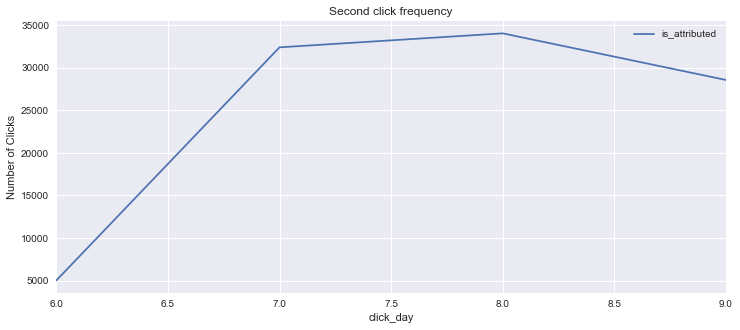

In [13]:
data['click_day'] = data['click_time'].dt.day

#check for hourly patterns
data[['click_day','is_attributed']].groupby(['click_day'], as_index=True).count().plot()
plt.title('Second click frequency')
plt.ylabel('Number of Clicks')

In [77]:
data.drop(['attributed_time','click_time'],axis = 1, inplace = True)

ValueError: labels ['attributed_time' 'click_time'] not contained in axis

In [78]:
Target = ['is_attributed']
Feature = data.columns.tolist()
Feature.remove('is_attributed')#['ip', 'app', 'device', 'os', 'channel']

In [79]:
train,test = train_test_split(data, train_size = 0.7, test_size = 0.3, random_state = 123)
# clf = xgboost.XGBClassifier()
# clf.fit(train[Feature],train[Target])
# pred = clf.predict(test[Feature])

In [136]:
roc_auc_score(pred, test[Target])

ValueError: continuous format is not supported

### LightGBM

In [80]:
x, y = train[Feature].values, train[Target].values.ravel()
train_data = lgb.Dataset(x,label = y)
test_data = lgb.Dataset(test[Feature].values, label = test[Target].values)

param = {
    'application':'binary',
    'objective':'binary',
    'metirc':'auc',
#     'is_unbalance':'true',
    'scale_pos_weight': 50,
    'boosting':'gbdt',
    'num_leaves':31,
    'feature_fraction':0.5,
    'bagging_freq':20,
    'learning_rate':0.05,
    'verbose':0
}

In [81]:
clf_lgb = lgb.train(param, train_data)
pred_prob = clf_lgb.predict(test[Feature].values)
pred_01 = np.where(pred_prob>0.5,1,0)
roc_auc_score(test[Target].values, pred_prob)

0.99342995626880737

In [45]:
roc_auc_score(test[Target].values, pred_01)
print(f1_score(test[Target],pred_01))
print(recall_score(test[Target],pred_01))
print(precision_score(test[Target],pred_01))
print(5*precision_score(test[Target],pred_01)*recall_score(test[Target],pred_01)/(4*precision_score(test[Target],pred_01)+recall_score(test[Target],pred_01)))

0.648351648352
0.746835443038
0.572815533981
0.704057279236


In [46]:
confusion_matrix(test[Target].values, pred_01)

array([[29877,    44],
       [   20,    59]])

Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x1a1917f780>>
Traceback (most recent call last):
  File "/Users/apple/anaconda/lib/python3.6/site-packages/xgboost/core.py", line 368, in __del__
    if self.handle is not None:
AttributeError: 'DMatrix' object has no attribute 'handle'


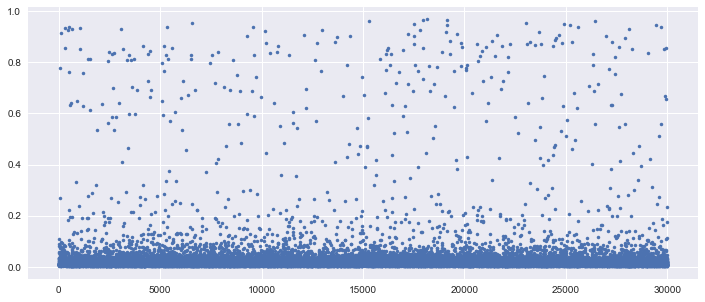

In [18]:
plt.plot(pred_prob,".")
plt.show()

In [104]:
print(train[Target].sum()/train[Target].count())
print(test[Target].sum()/test[Target].count())

is_attributed    0.002114
dtype: float64
is_attributed    0.002633
dtype: float64


In [153]:
clf_lgb.feature_name()
train.columns

Index(['ip', 'app', 'device', 'os', 'channel', 'is_attributed'], dtype='object')

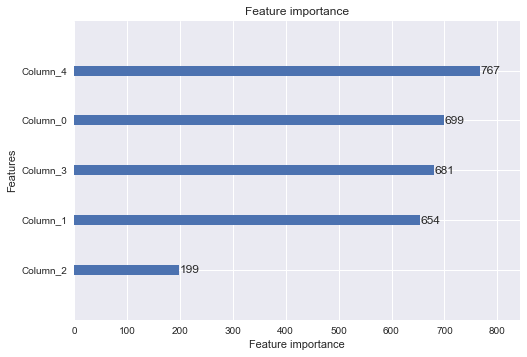

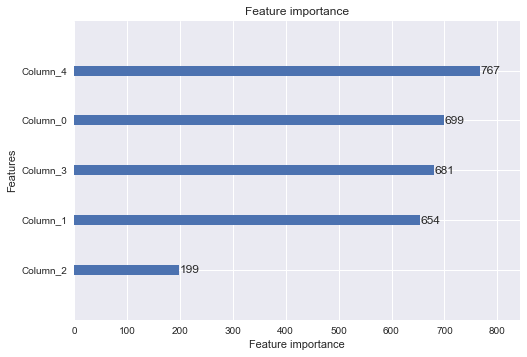

In [149]:
lgb.plot_importance(clf_lgb)
plt.show()

In [126]:
pred_prob = clf_lgb.predict(train[Feature].values)
pred_01 = np.where(pred_prob>0.5,1,0)

In [127]:
confusion_matrix(y,pred_01)
# roc_auc_score(y, pred_01)

array([[68825,  1027],
       [    0,   148]])

### Ignore below

In [18]:
# Machine Learning Algorithm Selection and Initialization
MLA = [
#     # Ensemble Methods
#     ensemble.AdaBoostClassifier(),
#     ensemble.BaggingClassifier(),
#     ensemble.ExtraTreesClassifier(),
#     ensemble.GradientBoostingClassifier(),
#     ensemble.RandomForestClassifier(),
    
#     # Gaussian Processes
#     gaussian_process.GaussianProcessClassifier(),
    
#     # GLM
#     linear_model.LogisticRegressionCV(),
#     linear_model.PassiveAggressiveClassifier(),
#     linear_model.RidgeClassifierCV(),
#     linear_model.SGDClassifier(),
#     linear_model.Perceptron(), #? need to know how this model will work
    
#     # Naive Bayes # need to know these two classifier?
#     naive_bayes.BernoulliNB(),
#     naive_bayes.GaussianNB(), 
    
#     # Nearest Neighbor
#     neighbors.KNeighborsClassifier(),
    
#     # SVM
#     svm.SVC(probability=True),
#     svm.NuSVC(probability=True),
#     svm.LinearSVC(),
    
#     # Trees
#     tree.DecisionTreeClassifier(),
#     tree.ExtraTreeClassifier(),
    
#     # Discriminant Analysis ? need to know this model better
#     discriminant_analysis.LinearDiscriminantAnalysis(),
#     discriminant_analysis.QuadraticDiscriminantAnalysis(),
    
    # xgboost
    xgboost.XGBClassifier()
]

# Split dataset in cross-validation, and alternative way to train_test_split
# run model 10x with 60/30 split intentionally leaving out 10%
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0)

# create table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters', 'MLA Train Accuracy Mean', 'MLA Test Accuracy Mean',
              'MLA Test Accuracy 3*STD', 'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

# create table to compare MLA predictions
MLA_predict = data[Target]

# index through MLA and save performance to table
row_index = 0
for alg in MLA:
    
    # set name and parameters
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    
    # score model with cross validation
    cv_results = model_selection.cross_validate(alg, data[Feature], data[Target], cv = cv_split, scoring = 'roc_auc')
    
    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3
    
    #save MLA predictions
    alg.fit(data[Feature], data[Target])
    MLA_predict[MLA_name] = alg.predict(data[Feature])
    
    row_index += 1

MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)



/Users/apple/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/apple/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ValueError: DataFrame.dtypes for data must be int, float or bool.
Did not expect the data types in fields click_time

In [12]:
# reduce sample size, include all fraud data(data_1) and include equal size of non-fraud data(data_0)
data_1 = data[data.is_attributed == 1]
n_count = data_1.shape[0]
data_0 = data[data.is_attributed == 0].sample(n_count)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [41]:
n_count = data.shape[0]
data = data[data.is_attributed == 0].sample(n_count)

ValueError: Cannot take a larger sample than population when 'replace=False'

In [25]:
raw_data = pd.concat([data_0, data_1])

In [29]:
raw_data.describe()

,ip,app,device,os,channel,is_attributed
count,913692.000000,913692.000000,913692.000000,913692.000000,913692.000000,913692.0
mean,128312.334249,20.868175,26.714655,23.594949,237.174209,0.5
std,96738.193380,27.213512,239.636593,55.264485,126.051646,0.5
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,50328.000000,9.000000,1.000000,13.000000,128.000000,0.0
50%,103351.000000,15.000000,1.000000,19.000000,213.000000,0.5
75%,191863.000000,23.000000,1.000000,24.000000,328.000000,1.0
max,364778.000000,768.000000,4223.000000,866.000000,498.000000,1.0


In [33]:
raw_data.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
178706976,73144,9,1,19,127,2017-11-09 14:04:29,NaN,0
13488688,202844,25,1,25,259,2017-11-07 01:09:59,NaN,0
49473637,2388,3,1,8,409,2017-11-07 12:40:22,NaN,0
76634207,121683,4,1,19,101,2017-11-08 02:20:30,NaN,0
107880312,186808,12,1,13,265,2017-11-08 11:58:41,NaN,0


In [34]:
# drop attributed_time coz too many missing and no data in test set
raw_data.drop('attributed_time', inplace = True)

# change string to datetime
raw_data['click_time'] = pd.to_datetime(raw_data['click_time'])

In [63]:
ax.bar(raw_data['click_time'], raw_data[raw_data['is_attributed'] == 1].is_attributed, width=10)
ax.xaxis_date()

plt.show()

ValueError: incompatible sizes: argument 'height' must be length 913692 or scalar

In [61]:
plt.hist(x = raw_data['click_time'], y=raw_data['is_attributed'],
         stacked = True, label = ['Survived','Dead'])
plt.legend()

TypeError: invalid type promotion

In [54]:
raw_data['is_attributed'].tail()

click_time
2017-11-09 15:59:21    1
2017-11-09 15:59:21    1
2017-11-09 15:59:26    1
2017-11-09 15:59:26    1
2017-11-09 15:59:33    1
Name: is_attributed, dtype: int64

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, roc_auc_score,confusion_matrix,f1_score, recall_score,precision_score
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
import lightgbm as lgb

# READ DATA
data = pd.read_csv('train.csv',header = 0)
Target = ['is_attributed']
Feature = ['ip', 'app', 'device', 'os', 'channel']

train,test = train_test_split(data, train_size = 0.9, test_size = 0.1, random_state = 123)
x, y = train[Feature].values, train[Target].values.ravel()
train_data = lgb.Dataset(x,label = y)
test_data = lgb.Dataset(test[Feature].values, label = test[Target].values)

param = {
    'application':'binary',
    'objective':'binary',
    'metirc':'auc',
#     'is_unbalance':'true',
    'scale_pos_weight': 50,
    'boosting':'gbdt',
    'num_leaves':31,
    'feature_fraction':0.5,
    'bagging_freq':20,
    'learning_rate':0.05,
    'verbose':0
}

clf_lgb = lgb.train(param, train_data)
pred_prob = clf_lgb.predict(test[Feature].values)
pred_01 = np.where(pred_prob>0.5,1,0)
print(roc_auc_score(test[Target].values, pred_prob))